# Group 66: AC209b Project Final Deliverables

## Predicting Covid-19 confirm cases using multiple source of data

Rock Zhou, Jingyuan Liu, Yaoyang Lin and Qiuyang Yin

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pylab as plt 
from wordcloud import WordCloud
from IPython.display import Image

from pandas.plotting import register_matplotlib_converters
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

%matplotlib inline

# 1. Introduction

需要大家BB

# 2. Data collection and EDA

## 2.1 COVID-19 Data

## 2.2 Tweet Data

### 2.2.1 Tweet Data collection

We know that social media is good platform to predict or indicate the outbreak of an epidemic. Hence we have collected COVID-19 related tweet data for analysis. 

We primarily used an online open-source COVID-19 tweets id Github repository {chen2020COVID} to help us filter virus related tweets. According to their description, the repository contains an ongoing collection of tweets IDs associated with the novel coronavirus COVID-19, which commenced on January 28, 2020. They leveraged Twitter’s streaming API to follow specific accounts and also collect in real-time tweets that mention specific keywords. The specific keywords list is also available in their repository.

Since the repository only includes tweet id (To comply with Twitter’s Terms of Service), we need to hydrate the tweed Id to obtain useful information like authors, texts, etc. We use our own twitter crawler to help us hydrate. Here is the process:

- Sample 1/50 tweet ids from each hour.
- Use twitter API to look up tweet information including author screen name, full text, language, place, favorite count and retweet count.
- If the tweet is an retweeted tweet, trace back to the original tweet. Use a set to guarantee no duplicated tweets. 

The original twitter crawler and proprocess code could be found in the folder TODO

The reason we only hydrate 1/50 of the original repository is that the original dataset is so enormous in quantity, and it is impossible to hydrate them in a short time based on twitter api's limit. Actually, hydrating 1/50 of original dataset costs us 10 hours, so it is estimated to take 21 days to hydrate the whole dataset.

At this stage we have collected more than 1,200,000 tweets related to the virus, from May 1st, 2020.

### 2.2.2 Tweet Data EDA

For the detailed notebook and original code, see [twitter eda notebook](./notebooks/twitter_ts_analysis.ipynb)

#### 2.2.2.1 Distribution of original twitter dataset

Before we turn twitter data into timeseries, we take a look at multiple aspects of tweets. Since this part involve huge dataset (with more than millions of tweets), we store original code in the eda notebook above and only put main outputs here.

We first take a look at active and popular COVID-19 users in the twitter platform. See figure below:

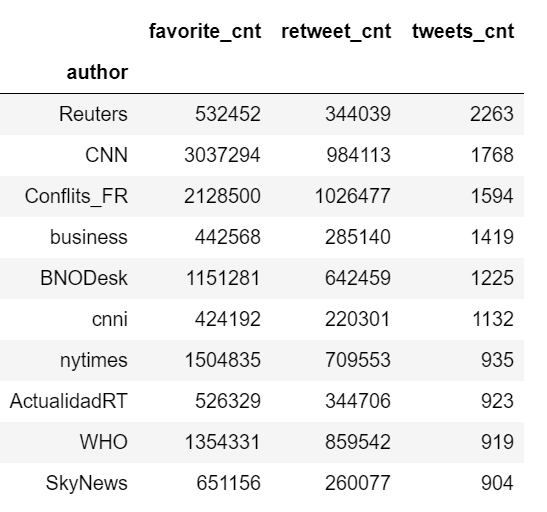

In [2]:
Image("pictures/EDA_twitter/active.PNG", width = 400, height = 300)

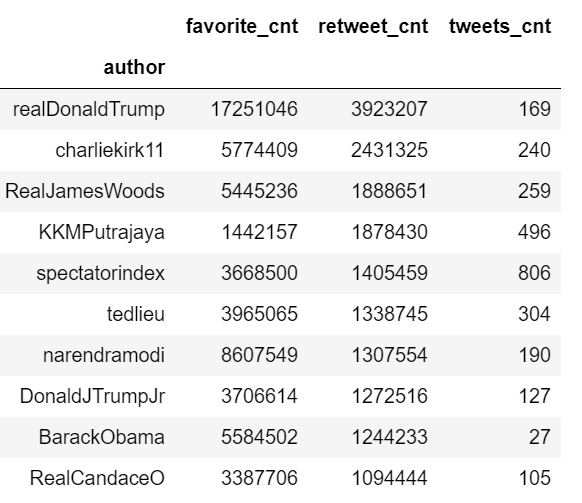

In [3]:
Image("pictures/EDA_twitter/popular.PNG", width = 400, height = 300)

We rank authors based of twitter number of favorite counts.  The results make sense inthat active authors tend to be press (Reuters, business, BNO, CNN, etc), while the popularusers tend to celebrities(Trump, Woods, etc)

Since we have the location information and language information,  we then take a look at what these distributions look like

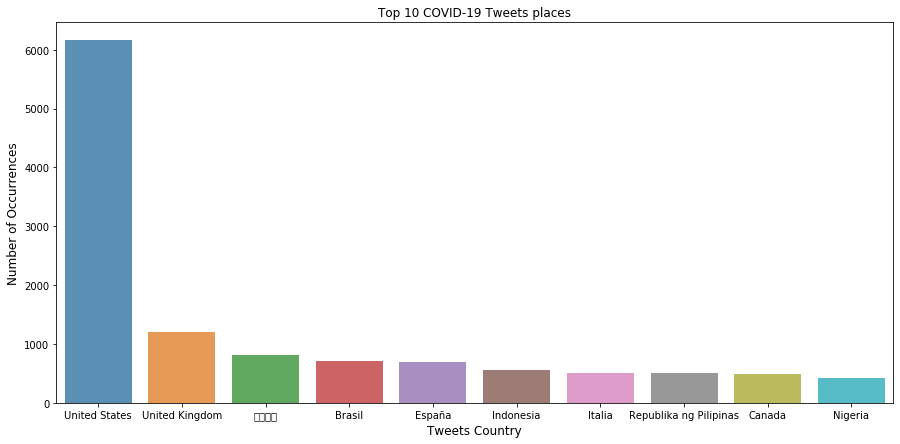

In [4]:
Image("pictures/EDA_twitter/Country.png", width = 400, height = 300)

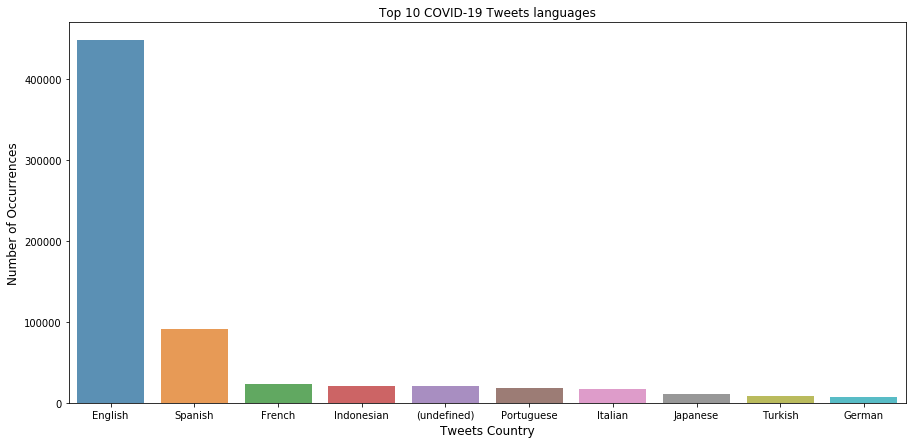

In [5]:
Image("pictures/EDA_twitter/languages.png", width = 400, height = 300)

We observe that most tweets do not have location information (only thousands of tweets have shared their locations).  Among tweets which have shared locations, US and UK are two  most  frequent  places,  followed  by  Brazil,  Indonesia,  etc.   This  is  related  to  the  user distribution.  For the language, most of the tweets are in English, while small portions arein Spanish, French, etc. In order to do the word count and feature engineering, we have to filter the English twitter.

We then take a look at the word use on tweets.  After cleaning, tokenizing and preprocessing,we draw a word cloud and filter the most frequent words in our dataset.  

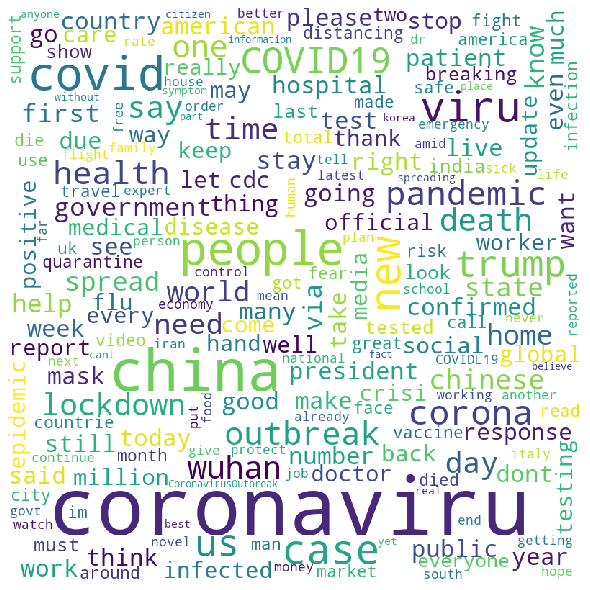

In [6]:
Image("pictures/EDA_twitter/wordCloud.png", width = 400, height = 300)

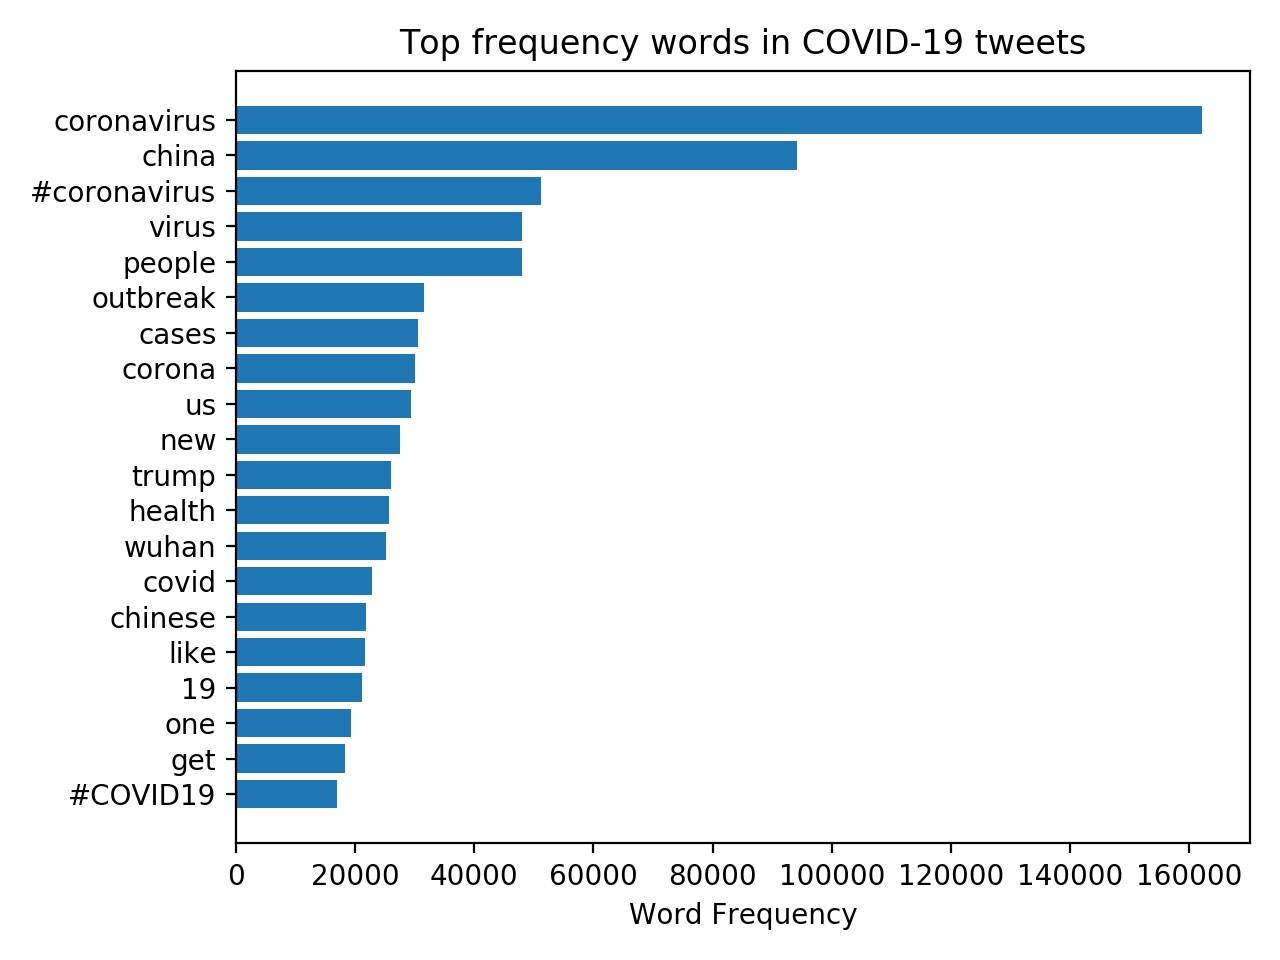

In [7]:
Image("pictures/EDA_twitter/word_freq.jpeg", width = 400, height = 300)

We can see that the word cloud tells us that the most frequent words are coronavirus, china, virus, people, outbreak, etc. These words are surly related to what we expected.

#### 2.2.2.2 Twitter timeseries data

Since our problem is related to time series, ultimately we are using some time series data. Here we plot two possible features: the twitter number and word use over time.

In [8]:
dat = pd.read_csv("../twitter_data/twitter_release.csv")
dat['date'] = pd.to_datetime(dat['date'])
dat.head()

Chinawords  Italywords  USwords  Outbreakwords                date  \
0           1           0        2              0 2020-01-21 22:00:00   
1           4           0        2              0 2020-01-21 23:00:00   
2           1           0        2              0 2020-01-22 00:00:00   
3           0           0        1              0 2020-01-22 01:00:00   
4           1           0        3              0 2020-01-22 02:00:00   

      str_date  twitter_number  
0  01-21 22:00              68  
1  01-21 23:00             156  
2  01-22 00:00             129  
3  01-22 01:00             128  
4  01-22 02:00             243

The keywords for different features are as follows:

In [9]:
keywords = [['china','wuhan','chinese'],['italy','italian','italia'],['us', 'trump','states'],['outbreak', 'spreading']]

Text(0.5, 1.0, 'Number of tweets related to COVID-19 over time')

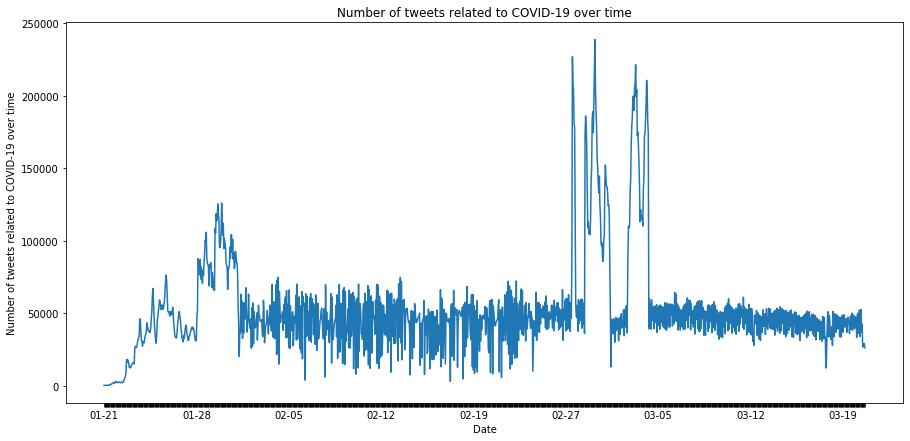

In [10]:
dates = list(dat['str_date'])
dates_ticks = [dates[i][:5] if i % (24*7) == 0 else '' for i in range(len(dates))]

f, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(dates, dat['twitter_number'])    
ax.set_xlabel('Date')
ax.set_ylabel('Number of tweets related to COVID-19 over time')
ax.set_xticklabels(dates_ticks)
ax.set_title('Number of tweets related to COVID-19 over time')

The overall flow of tweets number remain constant, which is contracy to the common belief. The possible reason is that the data provider can only collects tweets under the regulation of twitter terms of use, and thus the number is cut down.

Text(0.5, 1.0, 'Number of keywords related to COVID-19 over time')

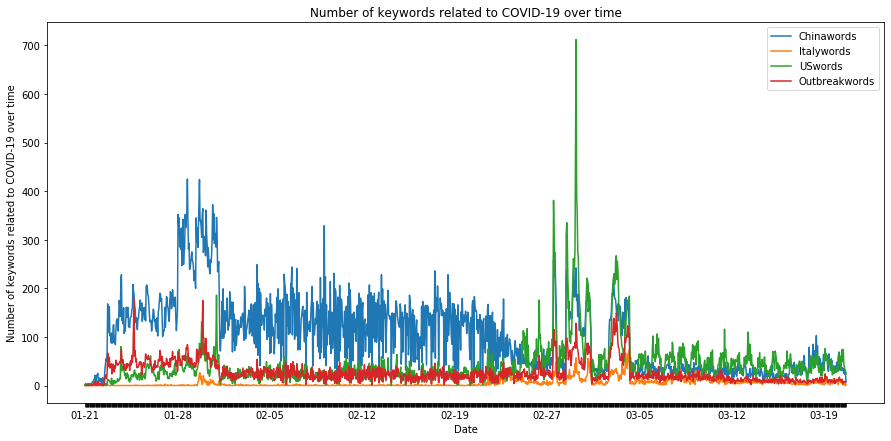

In [11]:
dates = list(dat['str_date'])
dates_ticks = [dates[i][:5] if i % (24*7) == 0 else '' for i in range(len(dates))]

f, ax = plt.subplots(1,1, figsize=(15,7))
cols = ['Chinawords','Italywords','USwords','Outbreakwords']
for col in cols:
    ax.plot(dates, dat[col], label=col)

ax.set_xlabel('Date')
ax.set_ylabel('Number of keywords related to COVID-19 over time')
ax.set_xticklabels(dates_ticks)
ax.legend()
ax.set_title('Number of keywords related to COVID-19 over time')

We can see that there are two peaks along the time axis: Jan 28 and Mar 4th, which corresponds to the outbreak in China and outbreak in US. The Italy has an outbreak around Feb, 20th.

For the word use over time, we can clearly see a different trend for China related words and US related words. These patterns can help us predict in the future models.

## 2.3 Weather Data

## 2.4 Google Trend Data

Internet searches data have been proven to be useful for predicting the outbreak of disease epidemics weeks earlier. Google is the largest search engine in the world and it offers a Google Trends website to show the public's interest over time. Google Trends could be used to show the popularity of specific search queries in Google Search across different regions in a given time period.

The search data would be useful for the prediction since people usually search for the symptoms of the virus before they went to hospital and they want to know what they can do to protect themselves as the virus spreads. Hence, we would like to mainly analyze three types of search query in the following study: query directly related to virus (coronavirus, covid), symptoms (dry cough, fever), and the precaution (face mask). 

We used an open sourced pytrends package for automating crawling data from Google Trends. All the search term has been translated by google translate API from English to the official language of the given area to ensure the quality of the data. For each specific search term, we collect the data from Google Trends for in the period of "2020-01-01" to "2020-04-05" for top 10 countries most affected by the virus (USA, Spain, Italy, France, Germany, China, Iran, UK, Turkey, Switzerland). We also collected the region level data for each country for detailed level analysis (eg. New York, New Jersey for USA; England, Northern Ireland for UK). Since Google does not provide service in China, we dropped China in the following analysis.

The detail of data collection could be found at [Google_trend_crawler notebook](https://github.com/DavidYQY/COVID-19-Prediction/blob/master/google_trend_data/google_trend_crawler.ipynb).


### 2.4.1 Country-level analysis

In [12]:
country_df = pd.read_csv ('../google_trend_data/google_trend_country.csv')

region_df = pd.read_csv ('../google_trend_data/google_trend_region.csv')

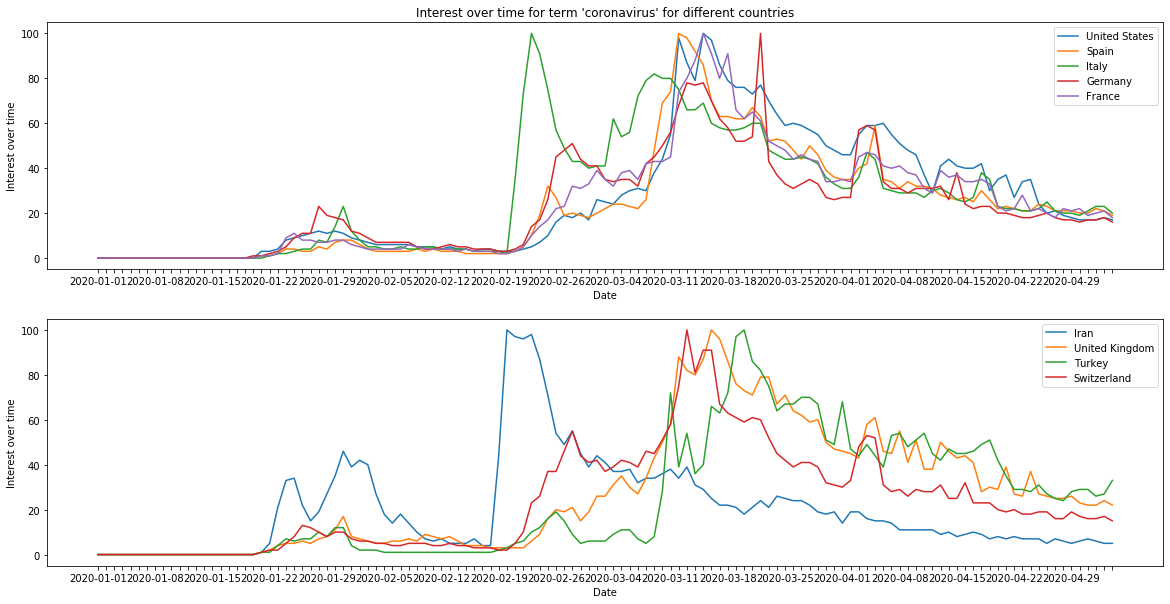

In [13]:
country_iso = ['US', 'ES', 'IT', 'DE', 'FR', 'IR', 'GB', 'TR', 'CH']

country_code_df = pd.read_csv("../google_trend_data/country_code.csv")

iso2name = {}
for i, row in country_code_df.iterrows():
    iso2name[row['iso']] = row['Country']
    

dates = list(country_df[country_df['iso']=='US']['date'])
dates_ticks = [dates[i] if i % 7 == 0 else '' for i in range(len(dates))]

f, ax = plt.subplots(2,1, figsize=(20,10))

for country in country_iso[:5]:
    ax[0].plot(dates, country_df[country_df['iso']==country]['coronavirus'], label=iso2name[country])

    
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Interest over time')
ax[0].set_xticklabels(dates_ticks)
ax[0].legend()
ax[0].set_title('Interest over time for term \'coronavirus\' for different countries')


for country in country_iso[5:]:
    ax[1].plot(dates, country_df[country_df['iso']==country]['coronavirus'], label=iso2name[country])
    
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Interest over time')
ax[1].set_xticklabels(dates_ticks)
ax[1].legend()
plt.savefig("pictures/EDA_GG/ggtrend_coronavirus_country.jpeg", dpi=200)

It is worth noticing that Google Trends only provide interest over time (a scale of 0-100) instead of the absolute value of search counts. The value is normalized by Google so that a value of 100 indicates the peak popularity for the term within the given period and a value of 50 indicates average popularity.

As we can see for each country in Figure, the search for 'coronavirus' would have a short spike and decrease after that peak. The spike would most likely due to the first few confirmed cases or death in the area. And search queries will decrease after the virus has already spread around the country so that the people get used to it. For example, the breakout of the virus in Italy and Iran is probably earlier than in other countries. The search for 'fever' has a similar trend as 'coronavirus', which means the search for symptoms could be useful to predict future cases. However, Turkey's 'fever' search remains to be at a high level, which potentially means that the virus is still very popular in the country.

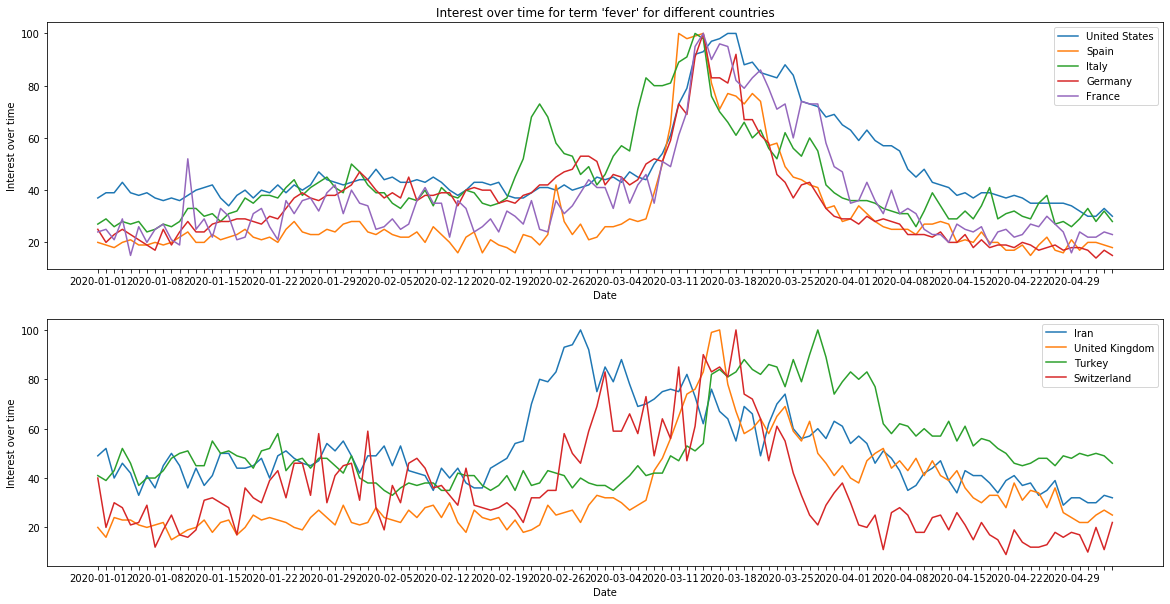

In [14]:
f, ax = plt.subplots(2,1, figsize=(20,10))

for country in country_iso[:5]:
    ax[0].plot(dates, country_df[country_df['iso']==country]['fever'], label=iso2name[country])
    
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Interest over time')
ax[0].set_xticklabels(dates_ticks)
ax[0].legend()
ax[0].set_title('Interest over time for term \'fever\' for different countries')


for country in country_iso[5:]:
    ax[1].plot(dates, country_df[country_df['iso']==country]['fever'], label=iso2name[country])
    
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Interest over time')
ax[1].set_xticklabels(dates_ticks)
ax[1].legend()
plt.savefig("pictures/EDA_GG/ggtrend_fever_country.jpeg", dpi=200)

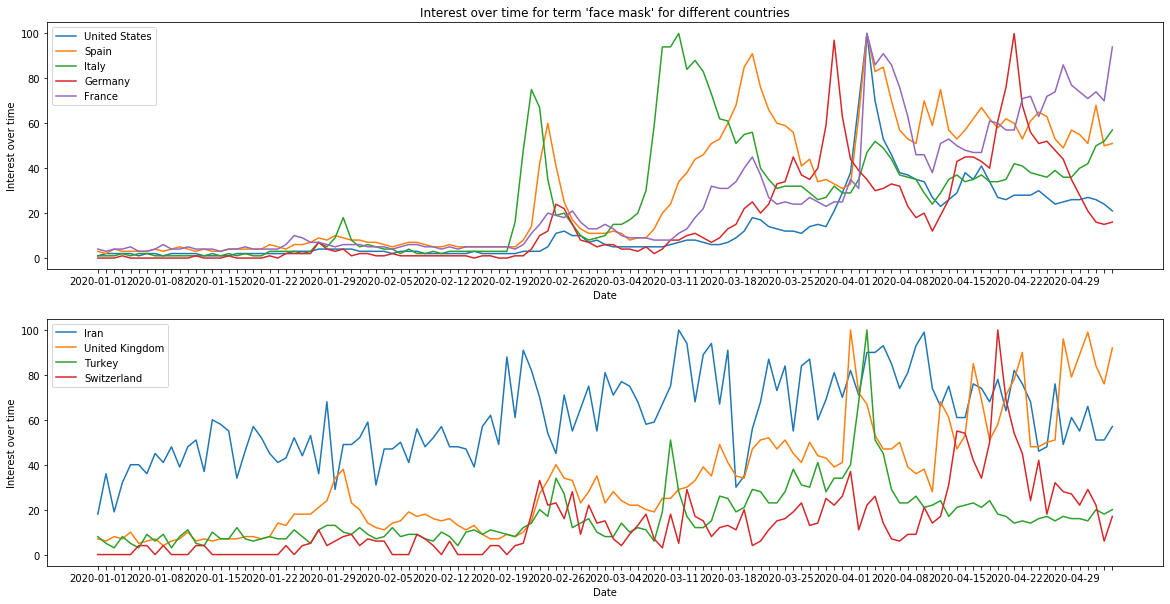

In [15]:
f, ax = plt.subplots(2,1, figsize=(20,10))

for country in country_iso[:5]:
    ax[0].plot(dates, country_df[country_df['iso']==country]['face mask'], label=iso2name[country])
    
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Interest over time')
ax[0].set_xticklabels(dates_ticks)
ax[0].legend()
ax[0].set_title('Interest over time for term \'face mask\' for different countries')


for country in country_iso[5:]:
    ax[1].plot(dates, country_df[country_df['iso']==country]['face mask'], label=iso2name[country])
    
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Interest over time')
ax[1].set_xticklabels(dates_ticks)
ax[1].legend()
plt.savefig("pictures/EDA_GG/ggtrend_face_mask_country.jpeg", dpi=200)

The trend for the search 'face mask' appears to be different across countries due to the publicity of governments since people would follow the suggestion of government. For example, the people in the US only show interest in face mask after April because the CDC advises them to wear a face mask. The data points of Iran is probably an outlier because of its custom. Since the trend for 'face mask' is much nosier than other terms, we would probably not included it in the prediction.


### 2.4.1 Country-level analysis

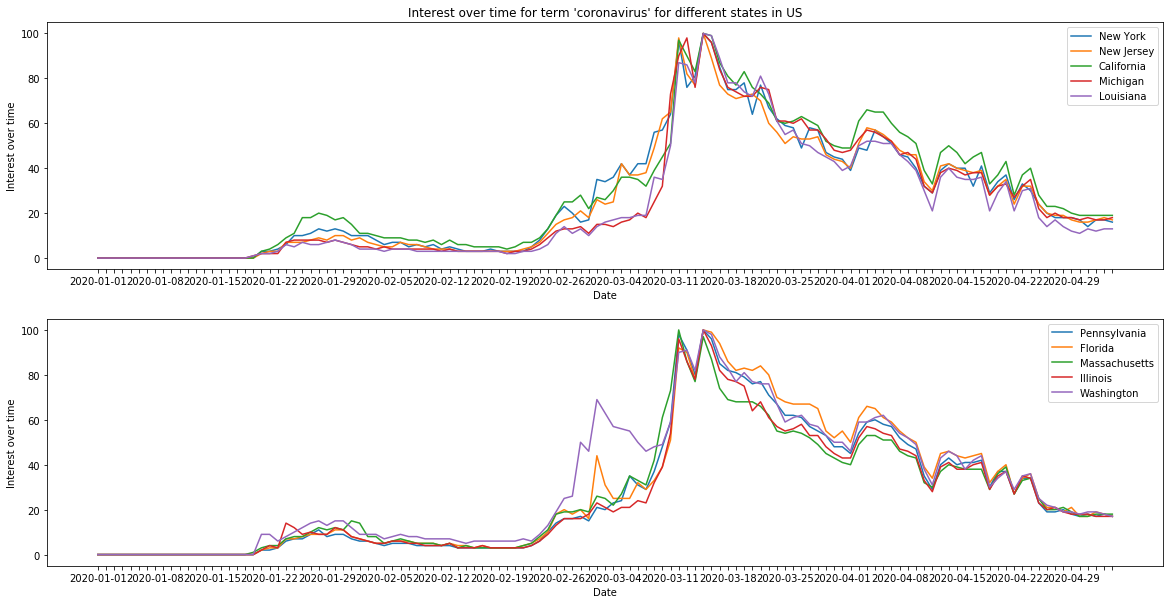

In [16]:
us_regions = list(region_df[region_df['iso']=='US']['geoName'].unique())

selected_regions1 = ['New York', 'New Jersey', 'California', 'Michigan', 'Louisiana']

selected_regions2 = ['Pennsylvania', 'Florida', 'Massachusetts', 'Illinois', 'Washington']

f, ax = plt.subplots(2,1, figsize=(20,10))

for region in selected_regions1:
    ax[0].plot(dates, region_df[region_df['geoName']==region]['coronavirus'], label=region)
    
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Interest over time')
ax[0].set_xticklabels(dates_ticks)
ax[0].legend()
ax[0].set_title('Interest over time for term \'coronavirus\' for different states in US')


for region in selected_regions2:
    ax[1].plot(dates, region_df[region_df['geoName']==region]['coronavirus'], label=region)
    
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Interest over time')
ax[1].set_xticklabels(dates_ticks)
ax[1].legend()
plt.savefig("pictures/EDA_GG/ggtrend_coronavirus_state.jpeg", dpi=200)


The search trend in different regions within the same country roughly follows the same trends with only small variations. For example, Washington and Califonia have a small spike in late February since the virus first spreads in these areas.

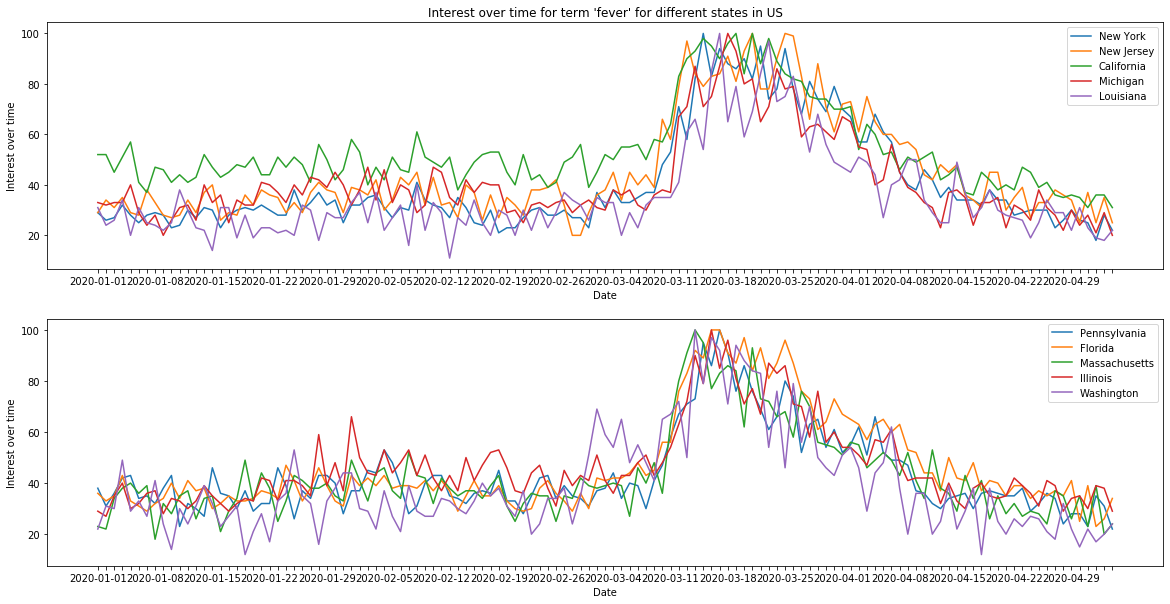

In [17]:
f, ax = plt.subplots(2,1, figsize=(20,10))

for region in selected_regions1:
    ax[0].plot(dates, region_df[region_df['geoName']==region]['fever'], label=region)
    
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Interest over time')
ax[0].set_xticklabels(dates_ticks)
ax[0].legend()
ax[0].set_title('Interest over time for term \'fever\' for different states in US')


for region in selected_regions2:
    ax[1].plot(dates, region_df[region_df['geoName']==region]['fever'], label=region)
    
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Interest over time')
ax[1].set_xticklabels(dates_ticks)
ax[1].legend()
plt.savefig("pictures/EDA_GG/ggtrend_fever_state.jpeg", dpi=200)

# 3. Predictive Models

## 3.1 Single source: SEIR

For the detailed notebook and original code, see [SEIR notebook](./notebooks/SEIR_r_version.ipynb). Note that this is a r notebook.

Since the work is written in R, to avoid conflict with other notebooks, here we only put the keys ideas and conclusions. The original code is located in TODO.

### 3.1.1 Our SEIR Model

The usual defined SEIR model is:

$$
\begin{split}
\frac{dS}{dt} &= \mu N - \nu S - \frac{\beta SI}{N} \\
\frac{dE}{dt} &= \frac{\beta SI}{N} - \sigma E - \nu E \\
\frac {dI}{dt} &= \sigma E - \gamma I - \nu I \\
\frac {dR}{dt} &= \gamma I - \nu R
\end{split}
$$

Where $\sigma$ is the rate of progression to infectious, $\mu$ is the birth rate and $\nu$ is the death rate.

Here we make further assumptions:

1. There is no birth rate
2. The only deaths in the population is due to the virus; the death will only occur in the Infectious period.

Under such assumptions, the SEIR model can be reformulated as:

$$
\begin{split}
\frac{dS}{dt} &= -\frac{\beta SI}{N} \\
\frac{dE}{dt} &= \frac{\beta S I}{N} - \sigma E\\
\frac {dI}{dt} &= \sigma E - \gamma I - \nu I \\
\frac {dR}{dt} &= \gamma I
\end{split}
$$

Then the basic reproduction number could be calculated as follows. There are two infected compartments E and I that determine the stability of the equation. If we linearize it and then the characteristic equation is:

$$
z^2 + (\sigma + \gamma + \nu)z + (\gamma + \nu)\sigma - \sigma \beta S_0 = 0
$$

This equation has all roots with negative real parts if and only if each coefficients is positive. then:

$$
(\gamma + \nu)\sigma - \sigma \beta S_0 > 0 \Leftrightarrow \frac{\beta S_0}{\gamma + \nu} >1
$$

Taks $S_0 = 1$, the basic reprodution number $R_0 = \frac {\beta}{\gamma + \nu}$ 


Below is our implementation of SEIR (thanks to http://statnet.org/tut/NewDCMs.html#example_1:_seir_model)

```r
SEIR <- function(t, t0, parms) {
  with(as.list(c(t0, parms)), {
    
    # Population size, which is changing because people dies
    num <- s.num + e.num + i.num + r.num
    
    # Effective contact rate and FOI from a rearrangement of Beta * c * D
    ce <- R0 / i.dur # the people amount one could spread to before he recovers, the speed is that divide by i.dur
    lambda <- ce * i.num/num # when people dies more the infection rate is higher
    
    dS <- -lambda*s.num
    dE <- lambda*s.num - (1/e.dur)*e.num
    dI <- (1/e.dur)*e.num - (1 - cfr)*(1/i.dur)*i.num - cfr*(1/i.dur)*i.num
    dR <- (1 - cfr)*(1/i.dur)*i.num 
    
    # Compartments and flows are part of the derivative vector
    # Other calculations to be output are outside the vector, but within the containing list
    list(c(dS, dE, dI, dR, 
           se.flow = lambda * s.num,
           ei.flow = (1/e.dur) * e.num,
           ir.flow = (1 - cfr)*(1/i.dur) * i.num,
           d.flow = cfr*(1/i.dur)*i.num),
         num = num,
         i.prev = i.num / num,
         ei.prev = (e.num + i.num)/num)
  })
}
```

Here the definition is equivalent, which reparameterizing $\beta$ to the variable ```ce```, $\sigma$ to the  ```1/e.dur```, $\nu$ to ```cfr*(1/i.dur)``` and $\gamma$ to ```(1 - cfr)*(1/i.dur)```, the $r_0$ here is equivalent to $\beta *$ ```i.dur```.

```e.dur``` can be interpreted as the duration of the exposed state, ```i.dur``` is the duration of the infectious state, and ```cfr```is the case fatality rate expressed as a proportion of those who will die among those infected. Here we fix other 3 parameters based on paper:

```r
e.dur = 5.2
i.dur = 2.3
cfr = 0.05
```

Note that here we only fit SEIR on Infected status, and the definition of Infected status is as follows:

$$
\text{Infected} = \text{Positive} - \text{Recovered} - \text{Deaths}
$$

### 3.1.2 Model Fitting

Since SEIR model can only be solved via ode, we can not write the explicit form of the best estimator but to define a loss function.

The loss function we used for is sum or squared log error. Recall $y_{ij}$ is the infection number in state $i$ on the $j$th day, and $\hat{y_{ij}}$ is the predicted infected number of SEIR model, then:

$$
\text{Loss for state i} = \sum_j(\log(\hat y_{ij}) - \log(y_{ij}))^2
$$

Given loss function we can optim the function via a set of optization methods like Nelder and Mead("Nelder-Mead") or Byrd("L-BFGS-B") built in R ```optim```.

### 3.1.3 Stagewise model

We first take a look at the Infected number across states:

In [18]:
Image("pictures/SEIR/trend1.png", width = 1000, height = 800)

And on the log scale:

In [19]:
Image("pictures/SEIR/trend2.png", width = 1000, height = 800)

One could see in the plot that there's a clear linear growth from Apr-01 onward. On the other hand, with log scale in the second plot the exponential growth pattern is quite clear before May-15. 

With this observation, we assume a SEIR model at the begining and then transfer to simple linear growth. 

We define the following two-period model:

Two period model:

$$
\begin{split}
y[1:\text{knot}] &\sim \text{SEIR}(R_0) \\
y[\text{knot}:] &\sim k \cdot\text{days} + b
\end{split}
$$


The optimal tradeoff point can be found by simple grid search.

### 3.1.4 Fitting result and Visualization

In [20]:
Image("pictures/SEIR/fit1.png", width = 1000, height = 800)

In [21]:
Image("pictures/SEIR/fit2.png", width = 1000, height = 800)

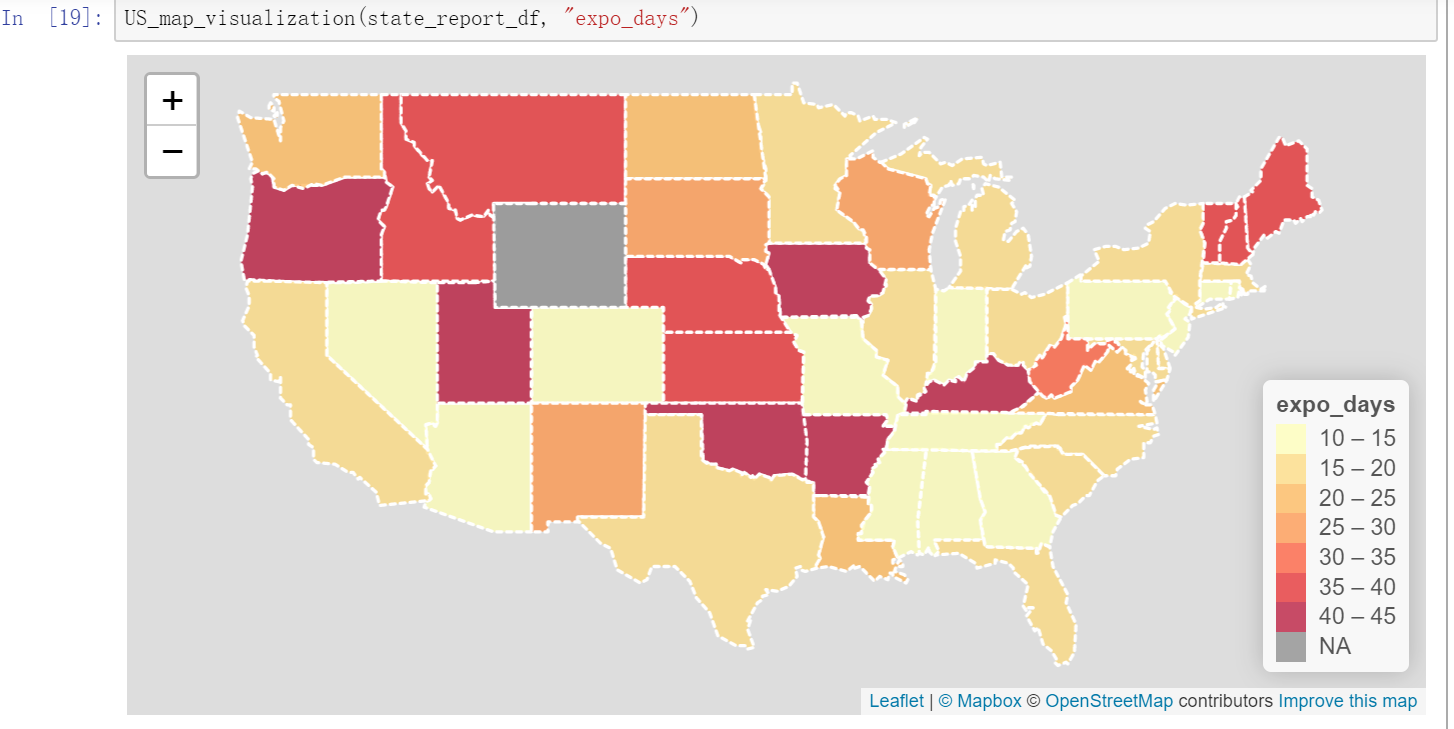

In [22]:
Image("pictures/SEIR/visualization.PNG", width = 1000, height = 800)

TODO

## 3.2 Single source:  ARIMA

## 3.3 Multiple source: Linear

In this section, we would include the variables other than the previous date data for the prediction task. For this purpose we will clean up the dataset and add new features. Since the weather data is only updated to 04/11/2020, we used the data from 01/22/2020 to 04/11/2020 for this prediction task. Each state of the US is trained individually in the model since they are in different phases of the virus outbreak.

In [23]:
# read in confirmed cases
all_data = pd.read_csv("../dataset_all.csv")
all_data = all_data[all_data.columns[1:]]
all_data

date state  positive  death   total  Chinawords  Italywords  \
0     2020-04-11    AK     257.0    8.0    7732         918          97   
1     2020-04-11    AL    3191.0   91.0   21249         918          97   
2     2020-04-11    AR    1226.0   24.0   18578         918          97   
3     2020-04-11    AZ    3393.0  108.0   40530         918          97   
4     2020-04-11    CA   19472.0  609.0  185276         918          97   
...          ...   ...       ...    ...     ...         ...         ...   
1438  2020-01-26    WA       1.0    0.0       1        3802           1   
1439  2020-01-25    WA       1.0    0.0       1        3558           2   
1440  2020-01-24    WA       1.0    0.0       1        3207           0   
1441  2020-01-23    WA       1.0    0.0       1        1436           3   
1442  2020-01-22    WA       1.0    0.0       1         199           0   

      USwords  Outbreakwords  twitter_number  ...    stp  wdsp  prcp  fog  \
0        1240            188         1047513  ...   27.6   7.1  0.00    0   
1        1240            188         1047513  ...  999.9   5.7  0.00    0   
2        1240            188         1047513  ...    3.8   4.4  0.00    0   
3        1240            188         1047513  ...  965.1   3.8  0.00    0   
4        1240            188         1047513  ...    9.0   3.7  0.00    0   
...       ...            ...             ...  ...    ...   ...   ...  ...   
1438      708           1142         1356180  ...  875.6   2.7  0.55    1   
1439      448           1320          998717  ...  876.5   1.5  0.14    1   
1440      487           1054          660769  ...  874.9   2.2  1.13    1   
1441      107            524          186460  ...  878.0   2.7  0.52    1   
1442       57             45           28520  ...  874.8   2.3  0.42    1   

      coronavirus  covid  dry cough  fever  shortness of breath  face mask  
0              32     62          0     21                    0         33  
1              33     58          0     35                   40         37  
2              33     56          0     27                   66         30  
3              41     67         19     43                    0         41  
4              39     75         15     51                   45         44  
...           ...    ...        ...    ...                  ...        ...  
1438           12      0         13     35                   58          6  
1439           10      0         14     53                   21          3  
1440            8      0          0     36                   19          2  
1441            6      0         12     33                   36          1  
1442            9      0         25     17                   19          1  

[1443 rows x 21 columns]

In [24]:
def get_previous_date(date, interval):
    return str(datetime.strptime(date, "%Y-%m-%d").date() - timedelta(days=interval))

def find_row(date, state, df, col):
    df2 = df[df["date"] == date]
    res = df2[df2["state"] == state]
        
    if len(res) == 0:
        return None
    
    return res[col].values[0]

all_data['t-1'] = 0
all_data['t-2'] = 0
all_data['t-3'] = 0

all_data['keep_data'] = False

# build data set, only keep data that has previous date data
for i, row in all_data.iterrows():
    date = row['date']
    state = row['state']
    
    keep_data = True
    val = find_row(get_previous_date(date, 3), state, all_data, "positive")
    all_data.at[i,'t-3'] = val
    if val == None:
        continue
        
    val = find_row(get_previous_date(date, 2), state, all_data, "positive")
    all_data.at[i,'t-2'] = val
    if val == None:
        continue
        
    val = find_row(get_previous_date(date, 1), state, all_data, "positive")
    all_data.at[i,'t-1'] = val
    if val == None:
        continue
        
    cols = ["death", "twitter_number", "temp", "stp", "wdsp", "prcp", "fog",
            "coronavirus", "covid", "dry cough", "fever", "shortness of breath", "face mask"]
    for col in cols:
        val = find_row(get_previous_date(date, 1), state, all_data, col)
        all_data.at[i, col] = val
        if val == None:
            keep_data = False
            break
    
    all_data.at[i,'keep_data'] = keep_data


all_data = all_data[all_data["keep_data"] == True]
all_data


date state  positive  death   total  Chinawords  Italywords  \
0     2020-04-11    AK     257.0    7.0    7732         918          97   
1     2020-04-11    AL    3191.0   80.0   21249         918          97   
2     2020-04-11    AR    1226.0   23.0   18578         918          97   
3     2020-04-11    AZ    3393.0   97.0   40530         918          97   
4     2020-04-11    CA   19472.0  541.0  185276         918          97   
...          ...   ...       ...    ...     ...         ...         ...   
1435  2020-01-29    WA       1.0    0.0       1        7254          10   
1436  2020-01-28    WA       1.0    0.0       1        4063           5   
1437  2020-01-27    WA       1.0    0.0       1        3383           9   
1438  2020-01-26    WA       1.0    0.0       1        3802           1   
1439  2020-01-25    WA       1.0    0.0       1        3558           2   

      USwords  Outbreakwords  twitter_number  ...  coronavirus  covid  \
0        1240            188          995210  ...           41     64   
1        1240            188          995210  ...           42     62   
2        1240            188          995210  ...           43     72   
3        1240            188          995210  ...           50     70   
4        1240            188          995210  ...           51     79   
...       ...            ...             ...  ...          ...    ...   
1435     1082           1383          875551  ...           15      0   
1436      644           1202          989434  ...           14      0   
1437      644           1095         1356180  ...           12      0   
1438      708           1142          998717  ...           10      0   
1439      448           1320          660769  ...            8      0   

      dry cough  fever  shortness of breath  face mask      t-1      t-2  \
0            50     19                   45         37    246.0    235.0   
1            29     36                   17         30   2968.0   2769.0   
2            29     27                    0         29   1171.0   1119.0   
3            24     26                   39         39   3112.0   3018.0   
4            14     49                   35         46  19472.0  18309.0   
...         ...    ...                  ...        ...      ...      ...   
1435         12     16                   18          6      1.0      1.0   
1436         12     32                    0          2      1.0      1.0   
1437         13     35                   58          6      1.0      1.0   
1438         14     53                   21          3      1.0      1.0   
1439          0     36                   19          2      1.0      1.0   

          t-3  keep_data  
0       226.0       True  
1      2369.0       True  
2      1000.0       True  
3      2726.0       True  
4     16957.0       True  
...       ...        ...  
1435      1.0       True  
1436      1.0       True  
1437      1.0       True  
1438      1.0       True  
1439      1.0       True  

[1134 rows x 25 columns]

Different from ordinary linear regression tasks, we could not simply split train and test set randomly since the data points are chronologically dependent on each other. We reserve the data before 04/01/2020 as a training set and use the data after 04/01 as testing data. The dataset would be normalized by the z-score.

In [25]:
# split train test

train_data = all_data.query('date < "2020-04-01"')
test_data = all_data.query('date >= "2020-04-01"')

# no intercept
X_train = train_data[["t-3", "t-2", "t-1", "death", "twitter_number", "temp", "stp", "wdsp", "prcp", "fog",
            "coronavirus", "covid", "dry cough", "fever", "shortness of breath", "face mask"]]
y_train = train_data[['positive']]

X_test = test_data[["t-3", "t-2", "t-1", "death", "twitter_number", "temp", "stp", "wdsp", "prcp", "fog",
            "coronavirus", "covid", "dry cough", "fever", "shortness of breath", "face mask"]]
y_test = test_data["positive"]

X_train_normalized = (X_train-X_train.mean())/X_train.std()
X_test_normalized = (X_test-X_train.mean())/X_train.std()

We formulate the cumulative confirmed cases at time T as following equation, the intercept is not included in this model:

$$
\begin{equation*}
Y_t = a_i\sum_{i=0}^{3}{Y_{t-i}} + b_iD_{t-1} + c_i\sum_{i=0}^{4}{TE_i} + d_iTW + e_i\sum_{i=0}^{6}{G_i},
\quad\quad \\
\text{for $Y_t$ is the culmulative confirmed cases at time T}
\\
\text{for $D_{t-1}$ is the death cases at time T-1}
\\
\text{$TE_i$ is variables related to temprature (stp, wdsp, prcp, fog) at time T-1}
\\
\text{$TW$ is number of virus related Twitters at time T-1}
\\
\text{$G$ is google search index for key words at time T-1}
\\
\text{(coronavirus, covid, dry cough, fever, shortness of breath, face mask)}
\end{equation*}
$$

In [26]:
OLSModel = OLS(y_train, X_train_normalized).fit()
# OLSModel = OLS(y_train, X_train).fit_regularized(method = 'sqrt_lasso')
print(OLSModel.summary())

                                 OLS Regression Results                                
Dep. Variable:               positive   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              654.7
Date:                Sat, 09 May 2020   Prob (F-statistic):                        0.00
Time:                        16:35:36   Log-Likelihood:                         -4710.1
No. Observations:                 726   AIC:                                      9452.
Df Residuals:                     710   BIC:                                      9526.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [27]:
yhat = OLSModel.predict(X_test_normalized)
r2_testset = r2_score(y_test, yhat)
print("R2 on training sets: "+ str(OLSModel.rsquared))
print("R2 on test sets: "+ str(r2_testset))
print("MSE on training sets: "+ str(mean_squared_error(y_train, OLSModel.predict(X_train_normalized))))
print("MSE on test sets: "+ str(mean_squared_error(y_test, yhat)))

R2 on training sets: 0.936521078451206
R2 on test sets: 0.9985764795262406
MSE on training sets: 25278.96488197782
MSE on test sets: 644272.1791764026


/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


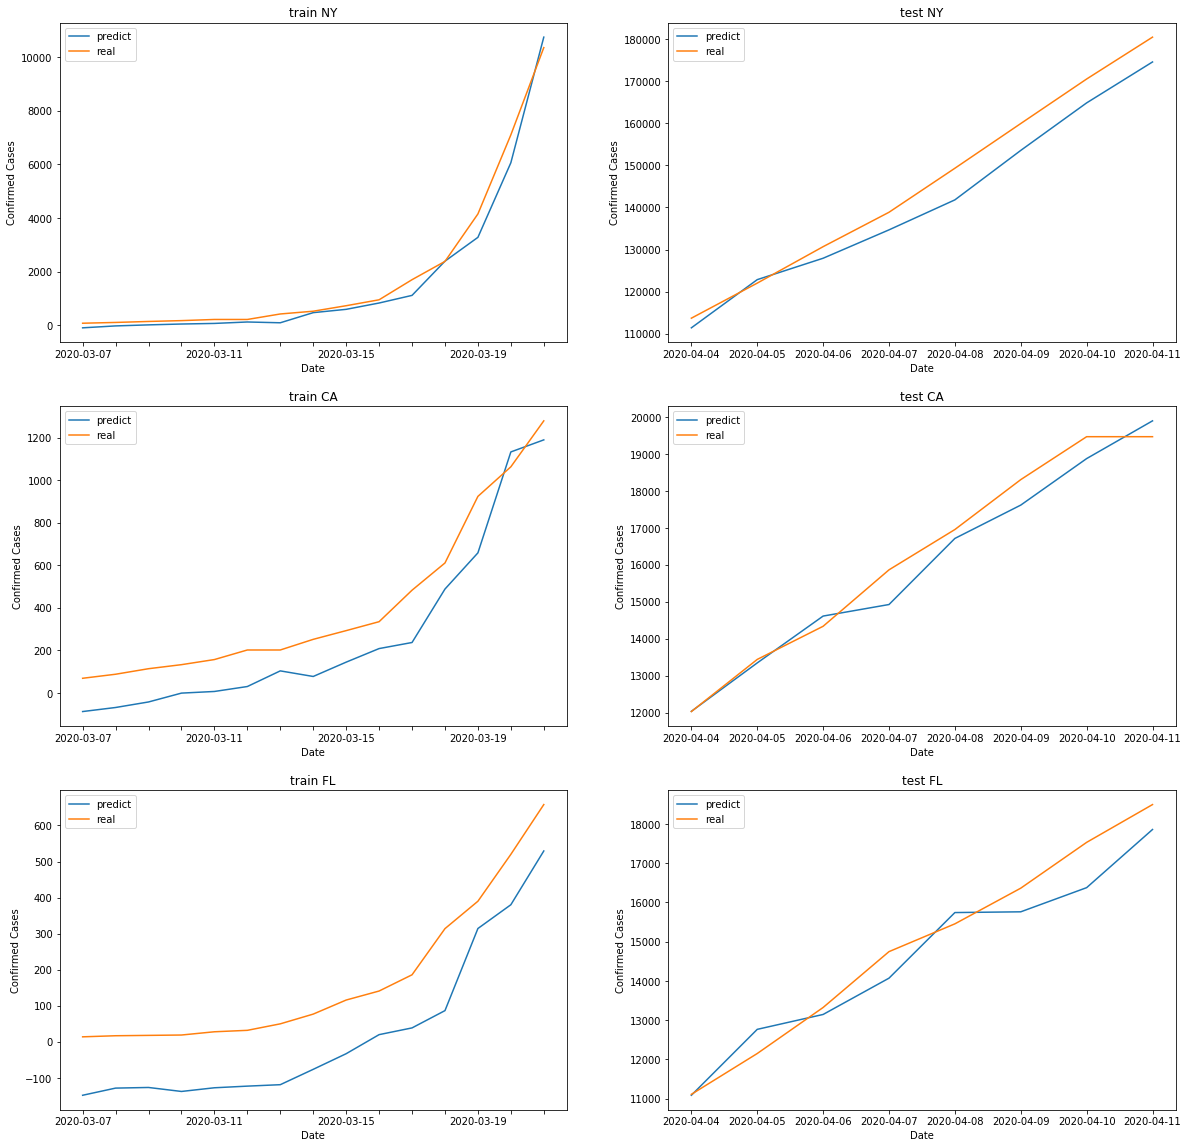

In [28]:
def plot_state_trend(train_data, test_data, model, X_train, X_test, states):
    f, ax = plt.subplots(len(states), 2, figsize=(20,20))
    
    train_data["predict"] = model.predict(X_train)
    test_data["predict"] = model.predict(X_test)
    
    for i in range(len(states)):
        
        df = train_data[train_data["state"]==states[i]]
        df = df.sort_values(by=["date"])

        dates = list(df["date"])
        ax[i, 0].plot(dates, df["predict"], label="predict")
        ax[i, 0].plot(dates, df["positive"], label="real")
        ax[i, 0].set_xlabel('Date')
        
        dates_ticks = [str(dates[i]) if i % 4 == 0 else '' for i in range(len(dates))]
                
        ax[i, 0].set_xticklabels(dates_ticks)
        ax[i, 0].set_ylabel('Confirmed Cases')
        ax[i, 0].legend()
        ax[i, 0].set_title('train '+ states[i])

        df = test_data[test_data["state"]==states[i]]
        df = df.sort_values(by=["date"])

        ax[i, 1].plot(df["date"], df["predict"], label="predict")
        ax[i, 1].plot(df["date"], df["positive"], label="real")
        ax[i, 1].set_xlabel('Date')
        ax[i, 1].set_ylabel('Confirmed Cases')
        ax[i, 1].legend()
        ax[i, 1].set_title('test '+ states[i])
    
    
plot_state_trend(train_data, test_data, OLSModel, X_train_normalized, X_test_normalized, ["NY", "CA", "FL"])

For New York and California, the forecast looks good. But as we could see, This linear model is better to capture the trend in the states with more confirmed cases. For the states with few cases, the gap between the actual trend and the forecast trend is wider. From suggestions of OLS Regression Results, we could probably see that variables such as internet search and twitter count is not significantly linearly related to the response variable. It is probably because there is a time lag between the search activity and the outbreak of the virus. Hence, we could not simply use the previous date search index for prediction. It is interesting to investigate this relationship in our future work. Below is the model using only previous three date data.

MSE on test sets: 378285.96761262


/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


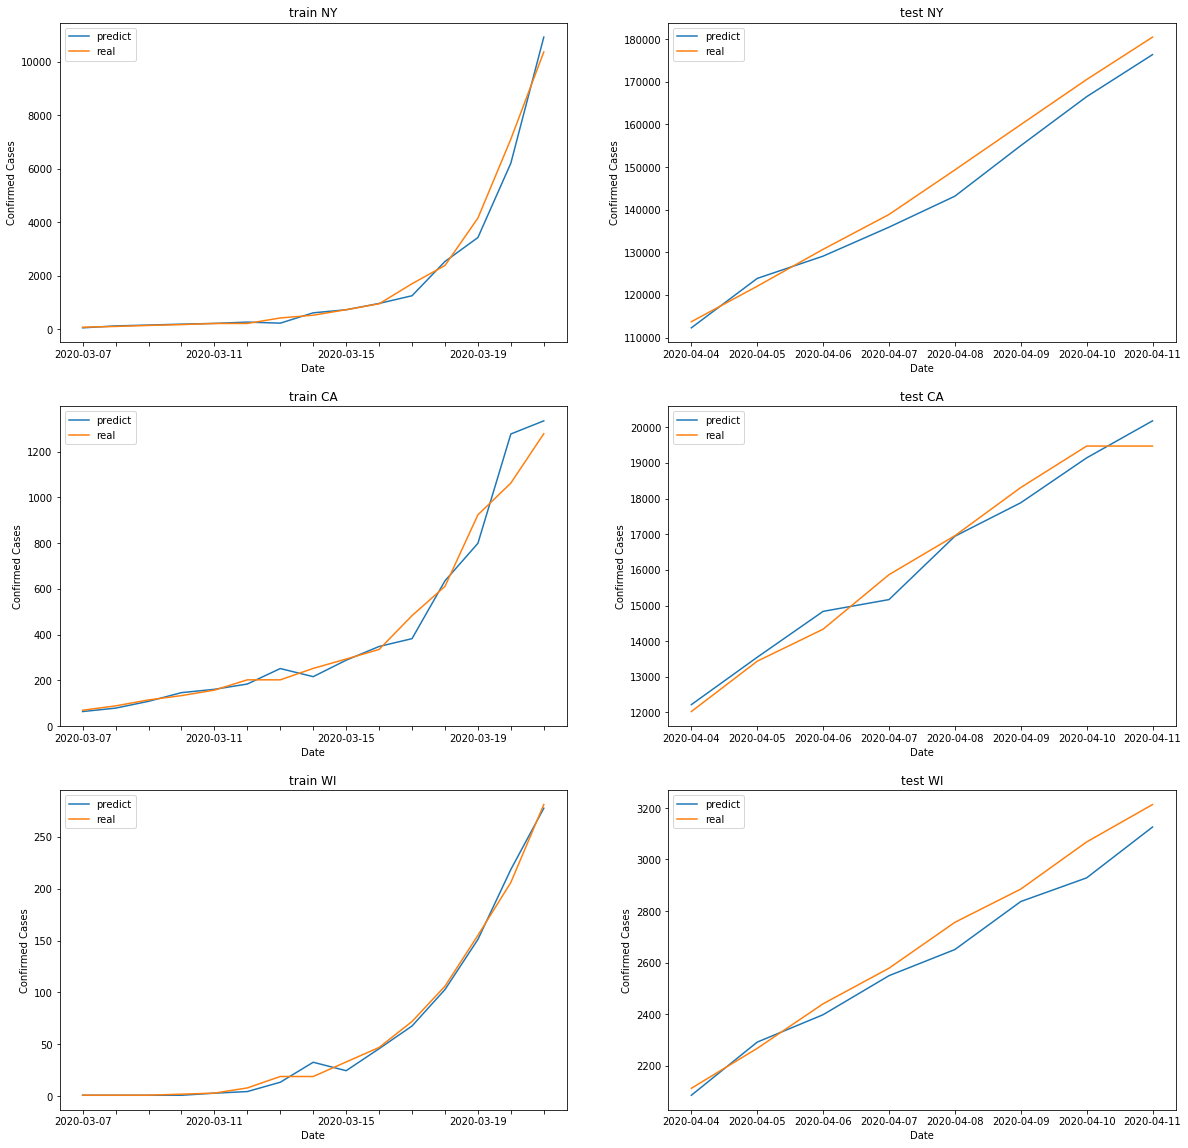

In [29]:
OLSModel = OLS(train_data[['positive']], train_data[["t-3", "t-2", "t-1"]]).fit_regularized(method = 'sqrt_lasso')

yhat = OLSModel.predict(test_data[["t-3", "t-2", "t-1"]])
print("MSE on test sets: "+ str(mean_squared_error(y_test, yhat)))

plot_state_trend(train_data, test_data, OLSModel, train_data[["t-3", "t-2", "t-1"]], test_data[["t-3", "t-2", "t-1"]], ["NY", "CA", "WI"])


## 3.4 Multiple source: RNN

# 4. Discussion

TODO

# 5. Conclusion

TODO

# Reference

[1]  E.  Chen,  K.  Lerman,  and  E.  Ferrara,  “Covid-19:  The  first  public  coronavirus  twitterdataset,”arXiv preprint arXiv:2003.07372, 2020.

[2] J.  Ginsberg,  M.  H.  Mohebbi,  R.  S.  Patel,  L.  Brammer,  M.  S.  Smolinski,  and  L.  Bril-liant, “Detecting influenza epidemics using search engine query data,”Nature, vol. 457,no. 7232, pp. 1012–1014, 2009.